In [1]:
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt

INFO: Using pytorch backend
INFO: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.
INFO: Created a temporary directory at /tmp/tmp2vkj5luw
INFO: Writing /tmp/tmp2vkj5luw/_remote_module_non_scriptable.py
/home/felix/Documents/Development/MLAE2/mlae/model/utils.py:24: UserWarning: Could not import hyperspherical_vae, VonMisesFisherMixtureDistribution will not be available.
  warnings.warn("Could not import hyperspherical_vae, VonMisesFisherMixtureDistribution will not be available.")


In [2]:
model = fff.ManifoldFreeFormFlow.load_from_checkpoint(
    "../../lightning_logs/von-mises-circle/version_0/checkpoints/last.ckpt"
)

In [3]:
torch.set_grad_enabled(False)

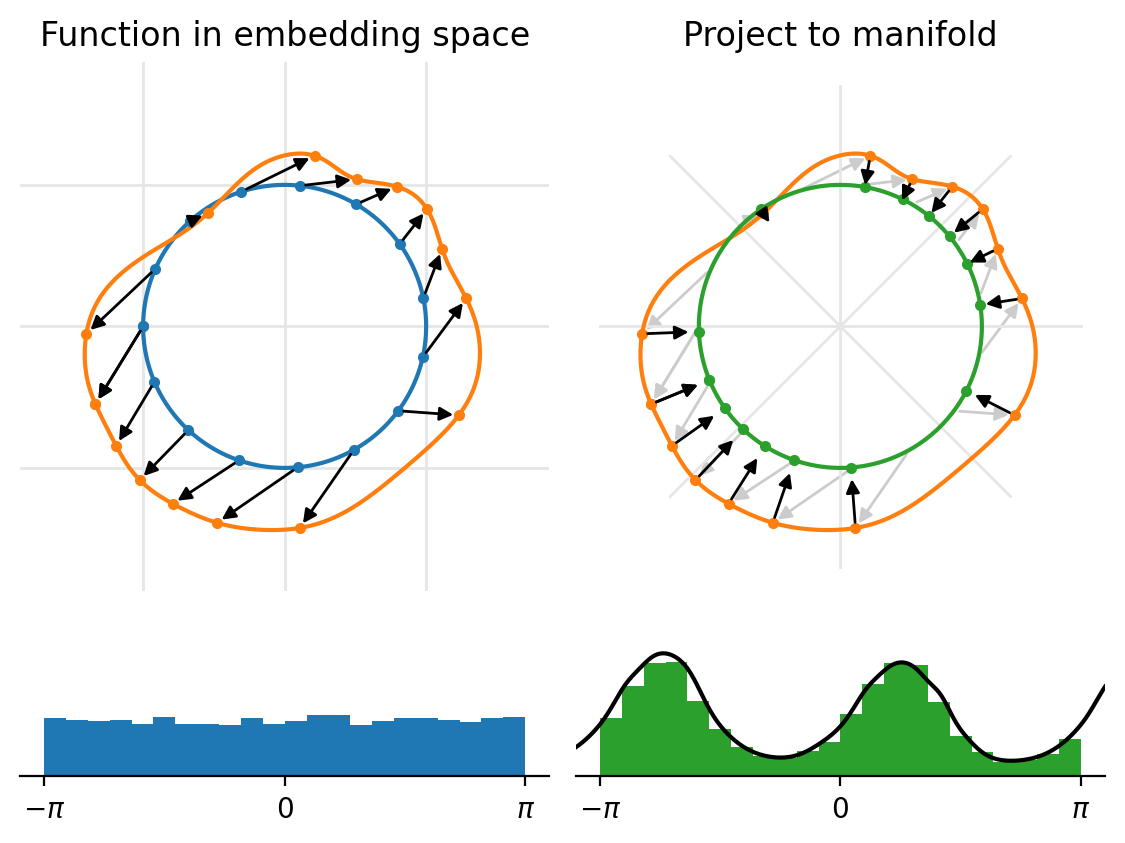

In [5]:
def euc_to_pol(x, distort=False):
    out = torch.stack([
        torch.atan2(x[:, 1], x[:, 0]),
        x.norm(2, -1)
    ], 1)
    if distort:
        # Exagerate deviations from circle
        out[:, 1] = (out[:, 1] - 1) * 3 + 1.3
    return out


def pol_to_euc(x):
    return x[:, 1:] * torch.stack([
        torch.cos(x[:, 0]),
        torch.sin(x[:, 0])
    ], 1)


fig, axes = plt.subplots(2, 2, sharex="row", sharey="row", figsize=(7, 5),
                         gridspec_kw=dict(height_ratios=[1, .2]))

# Generation process from equally spaced points in latent space
thetas_fine = torch.linspace(-torch.pi, torch.pi, 360)
z_fine = torch.stack([
    torch.cos(thetas_fine),
    torch.sin(thetas_fine)
], 1)
batch = model.apply_conditions([z_fine])
x1_fine = model.decode(batch.x0, batch.condition, project=False)
x1_proj_fine = model.manifold.projection(x1_fine)
x1_distorted_fine = pol_to_euc(euc_to_pol(x1_fine, True))
pol1_proj_fine = euc_to_pol(x1_proj_fine)

# Neural network acts in embedding
plt.sca(axes[0, 0])
plt.plot(*z_fine.T, label="Input data")
plt.plot(*x1_distorted_fine.T, label="Raw output")
subset = torch.linspace(0, len(thetas_fine) - 1, 16).long()
ms = 3
plt.plot(*z_fine[subset].T, "C0o", label="Selected raw output", ms=ms)
plt.plot(*x1_distorted_fine[subset].T, "C1o", label="Selected raw output", ms=ms)
for x_in, x_out in zip(z_fine[subset], x1_distorted_fine[subset]):
    plt.annotate("", x_out, x_in, arrowprops=dict(
        arrowstyle='-|>', fc="k",
    ))
plt.axis("off")
plt.title("Function in embedding space")
axes[0, 0].set_aspect(1)
for pos in [-1, 0, 1]:
    plt.axhline(pos, c=".9", zorder=-1, lw=1)
    plt.axvline(pos, c=".9", zorder=-1, lw=1)


# Projection to circle
plt.sca(axes[0, 1])
plt.title("Project to manifold")
plt.plot(*x1_distorted_fine.T, "C1", label="Raw output")
plt.plot(*x1_proj_fine.T, "C2", label="Projected output")
plt.plot(*x1_distorted_fine[subset].T, "C1o", label="Selected raw output", ms=ms)
plt.plot(*x1_proj_fine[subset].T, "C2o", label="Selected raw output", ms=ms)
for x0, x_in, x_out in zip(
    z_fine[subset], x1_distorted_fine[subset], x1_fine[subset]
):
    plt.annotate("", x_in, x0, arrowprops=dict(
        arrowstyle='-|>', fc=".8", ec=".8"
    ), zorder=-1)
    plt.annotate("", x_out, x_in, arrowprops=dict(
        arrowstyle='-|>', fc="k",
    ))
# Hint at polar projection using fake grid
for theta in torch.linspace(0, 2 * torch.pi, 8 + 1)[:-1]:
    plt.plot([0, 1.7 * np.cos(theta)], [0, 1.7 * np.sin(theta)], c=".9", zorder=-1, lw=1)

plt.axis("off")
axes[0, 1].set_aspect(1)

# Lower plots: Show histograms
count = 10_000
for ax, samples, color in zip(axes[1], [
    model.get_latent("cpu").sample((count,)),
    model.sample((count,)),
], ["C0", "C2"]):
    plt.sca(ax)
    ax.spines[["left", "top", "right"]].set_visible(False)
    plt.hist(euc_to_pol(samples)[:, 0], "auto", density=True, fc=color)
    plt.yticks([])
    plt.xticks([-np.pi, 0, np.pi], ["$-\\pi$", "$0$", "$\\pi$"])
    plt.xlim(-1.1 * np.pi, 1.1 * np.pi)

# Show density in lower left plot
plt.sca(axes[1, 1])
thetas_fine = torch.linspace(-1.1 * torch.pi, 1.1 * torch.pi, 300)
z_fine = torch.stack([
    torch.cos(thetas_fine),
    torch.sin(thetas_fine)
], 1)
batch = model.apply_conditions([z_fine])
probs = model.exact_log_prob(batch.x0, batch.condition).log_prob.exp()
plt.plot(thetas_fine, probs, "k")

# Adjust spacing
plt.subplots_adjust(wspace=.05, hspace=0)
# plt.savefig("m-fff-projection.pdf", bbox_inches="tight")